## Running PhotoD with LSDB

In [1]:
import os

default_n_threads = 1
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from pathlib import Path

import jax
import lsdb
import matplotlib.pyplot as plt
import nested_pandas as npd
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
from dask import delayed
from dask.distributed import Client, get_worker
from dustmaps import sfd
from scipy.interpolate import griddata
from photod.bayes import makeBayesEstimates3d
from photod.locus import LSSTsimsLocus, subsampleLocusData, get3DmodelList
from photod.parameters import GlobalParams

dustmaps_cache = '/mnt/beegfs/scratch/data/dustmaps'
Path(dustmaps_cache).mkdir(exist_ok=True, parents=True)
import dustmaps.config; dustmaps.config.config['data_dir'] = dustmaps_cache
sfd.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [2]:
prior_map_url = "/mnt/beegfs/scratch/data/priors/hats/s82_priors"
prior_map_catalog = lsdb.read_hats(prior_map_url)
prior_map_catalog

,rmag,kde,xGrid,yGrid,Norder,Dir,Npix
npartitions=207,,,,,,,
"Order: 5, Pixel: 0",double[pyarrow],binary[pyarrow],binary[pyarrow],binary[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...


In [3]:
def eq_to_gal(df):
    ra = df["ra"]
    dec = df["dec"]
    coord = SkyCoord(ra, dec, unit='deg')
    gal = coord.galactic
    return df.assign(glon=gal.l.deg, glat=gal.b.deg)

s82_stripe_catalog = lsdb.read_hats(
    "/mnt/beegfs/scratch/data/Gaia-SDSS/hats/Gaia-SDSS",
    search_filter=lsdb.BoxSearch(ra=[-52, 60], dec=[-1.266, 1.266]),
).map_partitions(
    lambda df: eq_to_gal(df.rename(
        columns={f"psfmag_{b}": f"{b}mag" for b in "ugriz"} | {f"psfmagerr_{b}": f"{b}magErr" for b in "ugriz"}
    ).eval(
        """
        ug = umag - gmag
        gr = gmag - rmag
        ri = rmag - imag
        iz = imag - zmag
        ugErr = sqrt(umagErr*umagErr, gmagErr*gmagErr)
        grErr = sqrt(gmagErr*gmagErr, gmagErr*rmagErr)
        riErr = sqrt(rmagErr*rmagErr, imagErr*imagErr)
        izErr = sqrt(imagErr*imagErr, zmagErr*zmagErr)
        parallax_over_error = parallax / parallax_error
        """,
    ))
)
s82_stripe_catalog

,random_index,ra,dec,phot_g_mean_mag,parallax,parallax_error,source_id,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,objid,type,umag,gmag,rmag,imag,zmag,umagErr,gmagErr,rmagErr,imagErr,zmagErr,Norder,Dir,Npix,ug,gr,ri,iz,ugErr,grErr,riErr,izErr,parallax_over_error,glon,glat
npartitions=13,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 1, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float64,float64
"Order: 2, Pixel: 48",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 8",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
def merging_function(partition, map_partition, partition_pixel, map_pixel, globalParams, worker_dict, *kwargs):
    priorGrid = {}
    for rind, r in enumerate(np.sort(map_partition["rmag"].to_numpy())):
        # interpolate prior map onto locus Mr-FeH grid
        Z = map_partition[map_partition["rmag"] == r]
        Zval = np.frombuffer(Z.iloc[0]["kde"], dtype=np.float64).reshape((96, 36))
        X = np.frombuffer(Z.iloc[0]["xGrid"], dtype=np.float64).reshape((96, 36))
        Y = np.frombuffer(Z.iloc[0]["yGrid"], dtype=np.float64).reshape((96, 36))
        points = np.array((X.flatten(), Y.flatten())).T
        values = Zval.flatten()
        # actual (linear) interpolation
        priorGrid[rind] = griddata(
            points, values, (globalParams.locusData["FeH"], globalParams.locusData[globalParams.MrColumn]), method="linear", fill_value=0
        )
    gpu_device = jax.devices()[worker_dict[get_worker().id]]
    with jax.default_device(gpu_device):
        priorGrid = jax.numpy.array(list(priorGrid.values()))
        estimatesDf, _ = makeBayesEstimates3d(partition, priorGrid, globalParams, batchSize=100)
    # Append ra and dec to be able to later crossmatch
    return pd.concat([partition[["ra", "dec", "r_med_geo", "r_med_photogeo", "parallax_over_error", "rmag", "umag", "gr",]], npd.NestedFrame(estimatesDf)], axis=1)

In [5]:
locus_path = "../../data/MSandRGBcolors_v1.3.txt"
fitColors = ("ug", "gr", "ri", "iz")
LSSTlocus = LSSTsimsLocus(fixForStripe82=False, datafile=locus_path)
OKlocus = LSSTlocus[(LSSTlocus["gi"] > 0.2) & (LSSTlocus["gi"] < 3.55)]
locusData = subsampleLocusData(OKlocus, kMr=10, kFeH=2)
ArGridList, locus3DList = get3DmodelList(locusData, fitColors)
globalParams = GlobalParams(fitColors, locusData, ArGridList, locus3DList)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


In [6]:
quantile_cols = [f"{statisticsName}_quantile_{quantile}" for statisticsName in ["Mr","FeH","Ar","Qr"] for quantile in ["lo","median","hi"]]
estimate_cols = sorted([*quantile_cols,"MrdS","FeHdS","ArdS"])
col_names = ["ra","dec","r_med_geo","r_med_photogeo","parallax_over_error","rmag","umag","gr","glon","glat","chi2min",*estimate_cols]
meta = npd.NestedFrame.from_dict({ col: pd.Series([], dtype=np.float32) for col in col_names })
meta.index.name = "_healpix_29"
meta

,ra,dec,r_med_geo,r_med_photogeo,parallax_over_error,rmag,umag,gr,glon,glat,...,FeH_quantile_lo,FeH_quantile_median,FeHdS,Mr_quantile_hi,Mr_quantile_lo,Mr_quantile_median,MrdS,Qr_quantile_hi,Qr_quantile_lo,Qr_quantile_median
_healpix_29,,,,,,,,,,,,,,,,,,,,,


In [7]:
def get_worker_dict():
    res = s82_stripe_catalog._ddf.partitions[0:5].map_partitions(lambda df: pd.DataFrame.from_dict({"workers":[get_worker().id]}), meta={"workers": object}).compute()
    worker_ids = np.unique(res["workers"].to_numpy())
    worker_dict = {id: i for i, id in enumerate(worker_ids)}
    print(worker_dict)
    return worker_dict

In [8]:
with Client(n_workers=4) as client:
    worker_dict = get_worker_dict()
    print(worker_dict)
    delayed_global_params = delayed(globalParams)
    merge_lazy = s82_stripe_catalog.merge_map(prior_map_catalog, merging_function, globalParams=delayed_global_params, worker_dict=worker_dict, meta=meta)
    xmatch_result = merge_lazy.compute()
xmatch_result

/home/kmalanch/.virtualenvs/photoD/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44785 instead
  warnings.warn(


{'Worker-633b7d75-b798-4898-b317-ce0af5f1bd39': 0, 'Worker-84960edd-d4c6-4095-904d-67612e92a0cb': 1, 'Worker-9feffa31-f12d-4219-871c-5848d963f3b0': 2, 'Worker-d47fdb7f-2045-4178-9340-b77b95320622': 3}
{'Worker-633b7d75-b798-4898-b317-ce0af5f1bd39': 0, 'Worker-84960edd-d4c6-4095-904d-67612e92a0cb': 1, 'Worker-9feffa31-f12d-4219-871c-5848d963f3b0': 2, 'Worker-d47fdb7f-2045-4178-9340-b77b95320622': 3}


/home/kmalanch/.virtualenvs/photoD/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 78.95 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,ra,dec,r_med_geo,r_med_photogeo,parallax_over_error,rmag,umag,gr,glon,glat,...,FeH_quantile_lo,FeH_quantile_median,FeHdS,Mr_quantile_hi,Mr_quantile_lo,Mr_quantile_median,MrdS,Qr_quantile_hi,Qr_quantile_lo,Qr_quantile_median
_healpix_29,,,,,,,,,,,,,,,,,,,,,
29153808338,45.004978,0.01988,314.098663,313.454712,140.47131,14.1454,17.21501,0.83732,176.944767,-48.885267,...,NaN,NaN,0.291286,NaN,NaN,NaN,-27.945087,NaN,NaN,NaN
29640498453,45.00432,0.021048,306.347778,310.828705,26.857705,18.101839,21.903919,1.52433,176.942794,-48.884931,...,-0.590813,-0.278518,-11.072062,10.594156,10.078468,10.290326,-33.299908,10.864006,10.387707,10.568277
282950616891,45.048282,0.048254,614.936218,616.651428,45.99728,14.971,17.75176,0.79687,176.959371,-48.834395,...,-0.533224,-0.289617,-5.525905,5.296045,-0.168435,0.333894,-18.281178,5.988453,0.033629,0.588651
425704743710,45.02362,0.068419,814.872498,811.626465,18.006064,16.55686,20.05662,1.0364,176.911311,-48.838160,...,-0.392313,-0.203972,-14.542096,6.844335,6.338311,6.570840,-30.928381,6.997999,6.658961,6.791443
643735774625,44.993271,0.076334,1476.288086,1521.849976,13.096099,16.204041,18.44335,0.58482,176.870634,-48.854504,...,-0.442113,-0.229036,-10.431520,5.507360,4.881606,5.149137,-26.814789,5.637996,5.146863,5.345767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458764334488336214,315.027158,-0.037642,1023.075745,1106.234863,6.42036,17.969391,21.889391,1.393219,48.897672,-28.302597,...,-0.517343,-0.263206,-11.556311,8.095885,7.439503,7.790954,-23.818600,8.326488,7.885603,8.076653
3458764335048204908,315.029101,-0.038178,595.732178,593.664551,87.681984,13.2611,15.06771,0.43824,48.898293,-28.304536,...,NaN,NaN,0.559260,NaN,NaN,NaN,-27.933327,NaN,NaN,NaN
3458764488918291245,314.983418,-0.020028,390.564972,400.299591,16.613003,18.512329,22.417471,1.416811,48.889083,-28.256054,...,-0.485831,-0.235875,-14.399448,10.643343,10.224490,10.392323,-33.054119,10.704497,10.319132,10.462954


(43435, 29)


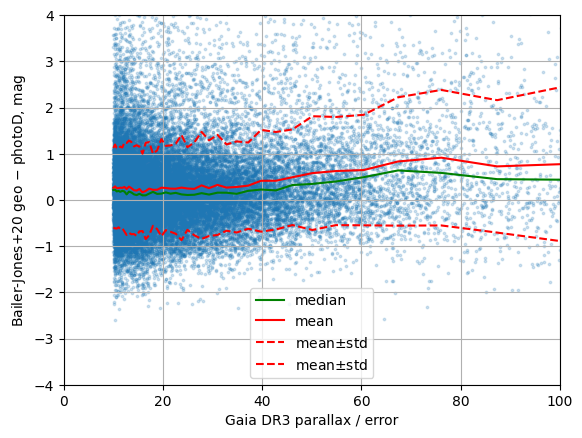

In [9]:
def pc_to_distmod(d):
    return 5.0 * np.log10(d / 10.0)

plot_samples = None
poe_window = 1000

df = xmatch_result.copy()
coord = SkyCoord(df["ra"], df["dec"], unit="deg")
# Coeeficient is for SDSS r-band, RV=3.1
# Taken from table 6, Shlafly & Finkbeiner 2011
# https://ui.adsabs.harvard.edu/abs/2011ApJ...737..103S/abstract
df["sfd_Ar"] = 2.285 * sfd.SFDQuery()(coord)
df["Mr_gaia_geo"] = df["rmag"] - pc_to_distmod(df["r_med_geo"]) - df["sfd_Ar"]
df["Mr_gaia_photogeo"] = df["rmag"] - pc_to_distmod(df["r_med_photogeo"]) - df["sfd_Ar"]
df = df.sort_values("parallax_over_error").query(
    "Mr_gaia_geo > 4"
    " and Mr_gaia_photogeo > 4"
    " and umag < 21"
    " and 0.2 < gr < 0.6"
    " and parallax_over_error >= 10"
)
print(df.shape)

poe = df["parallax_over_error"].to_numpy()

# obs = df["rmag"].to_numpy() - df["Qr_quantile_median"].to_numpy()
# mod = pc_to_distmod(df["r_med_geo_gaia_dist"]).to_numpy()
obs = df["Mr_quantile_median"].to_numpy()
mod = df["Mr_gaia_geo"].to_numpy()

residuals = mod - obs

poe_grid = poe[::poe_window][:-1]
medians = np.nanmedian(
    residuals[:len(residuals) // poe_window * poe_window].reshape(-1, poe_window),
    axis=1,
)
mean = np.nanmean(
    residuals[:len(residuals) // poe_window * poe_window].reshape(-1, poe_window),
    axis=1,
)
std = np.nanstd(
    residuals[:len(residuals) // poe_window * poe_window].reshape(-1, poe_window),
    axis=1,
)

idx_samples = None if plot_samples is None else np.random.default_rng(0).choice(len(residuals), plot_samples, replace=False)
plt.scatter(poe[idx_samples], residuals[idx_samples], marker='o', s=3, alpha=0.2)

plt.plot(poe_grid, medians, '-', color='green', label='median')
plt.plot(poe_grid, mean, '-', color='red', label='mean')
plt.plot(poe_grid, np.stack([mean - std, mean+std], axis=-1), '--', color='red', label=r'mean$\pm$std')

plt.xlim(0, 100)
plt.ylim(-4, 4)
plt.xlabel("Gaia DR3 parallax / error")
plt.ylabel("Bailer-Jones+20 geo $-$ photoD, mag")
plt.grid()
plt.legend()
plt.savefig("MYPLOT.png")

In [10]:
np.mean(df["Mr_quantile_median"] + df["Ar_quantile_median"] - df["Qr_quantile_median"])

np.float32(-0.011516952)